# Прогнозирование изменения ставки ЦБ (Baseline-решение)

### Описание проекта:

Baseline-решение задачи классификации направления изменения будущей ключевой ставки ЦБ РФ по семантике текущего пресс-релиза, величины инфляции, курса доллара, а также текущей ставки ЦБ.

### Цели проекта:

Цель данной работы построение бейзлайна и его улучшение с помощью простейших моделей, для предсказания направления изменения ставки рефинансирования ЦБ. Это наша отправная точка для сравнения и улучшения. 

### План работы:

0. Общая предобработка данных.
1. Минимальный бейзлайн.
2. Статистические методы :
    - Мешок слов плюс линейная модель
    - TF-IDF плюс линейная модель
    - N-граммы плюс Naive Bayes
3. Создание эмбеддингов:
    - Word2Vec плюс линейная модель
    - GloVe плюс линейная модель
4. Выводы

### Описание данных:

- `date` - дата публикации пресс-релиза
- `title` - заголовок пресс-релиза
- `release` - текст пресс-релиза
- `inflation` - годовая инфляция
- `rate` - величина ключевой ставки ЦБ, объявленная на следущем заседании
- `usd` - курс доллара
- `usd_cur_change_relative` - относительное изменение курса доллара, по сравнению с предыдущим заседанием
- `target_categorial` - категориальная метка направления изменения ключевой ставки ЦБ, 1 - повышение, -1 - понижение, 0 - без изменений.
- `target_absolute` - абсолютное изменение ключевой ставки ЦБ (следующее значение минус текущее)
- `target_relative` - относительное изменение ключевой ставки ЦБ (следующее значение делится на текущее)

In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from pymystem3 import Mystem
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

RANDOM_STATE = 41825352
DATASET_URL = '../data/cbr-press-releases.csv'

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/father/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/father/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/father/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Загрузим датасет пресс-релизов, полученных с сайта ЦБ РФ:

In [2]:
df = pd.read_csv(DATASET_URL, parse_dates=['date'])

## Общая предобработка данных

`rate` - величина ключевой ставки, которую объявят на следующем заседании. Мы хотели бы знать эту величину. Но мы знаем текущую ставку и эту информацию можно добавить в наши данные сдвинув ставку на один.

In [3]:
df['rate'] = df.rate.shift(1)

В сентябре 2013 года ЦБ ввел ключевую ставку, и назначил ее величину в 5,5% заполним пропущенное значение.

In [4]:
df.loc[0, 'rate'] = 5.5

Дату сделаем индексом, ссылку на пресс-релиз выбросим, эта переменная не поможет в предсказании таргета.

In [5]:
df.set_index('date', inplace=True)
df.drop('link', axis=1, inplace=True)

Для последнего релиза неизвестна целевая переменная (направление изменения ключевой ставки), поэтому исключим его из датасета и сохраним отдельно:

In [6]:
df.sort_values('date', inplace=True)
cur_pr = df.tail(1)
df = df[:-1]

Мы хотим предсказывать направление ставки рефинансирования `target_categorial`, выделим ее как целевую переменную. `target_absolute` и `target_relative` содержит в себе информацию о целевой переменной удалим их из матрицы признаков.

In [7]:
X = df.drop(['target_categorial', 'target_absolute', 'target_relative'], axis=1)
y = df['target_categorial']

## Минимальный безлайн 

Направление изменения ставки будем предсказывать таким, как в последнем решении. До 13 сентября ключевой ставки не существовало, поэтому мы не можем предсказать таким способом для первого наблюдения, будем оценивать качество бейзлайна без него.

In [8]:
y_pred = y.shift(1)
accuracy = accuracy_score(y[1:], y_pred[1:])
f1 = f1_score(y[1:], y_pred[1:], average='macro')
precision = precision_score(y[1:], y_pred[1:], average='macro')
recall = recall_score(y[1:], y_pred[1:], average='macro')
min_baseline = pd.DataFrame({'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}, index=['min_baseline'])

### Статистические методы

#### Мешок слов плюс линейная модель

Обучим мешок слов на пресс-релизах

In [9]:
mystem = Mystem()

def preprocessor(text):
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    return ' '.join(mystem.lemmatize(text))

vectorizer = CountVectorizer(
    lowercase=True,
    stop_words=list(stopwords.words('russian')),
    tokenizer=word_tokenize,
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

bow = vectorizer.transform(X.release)

/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['весь', 'свой', 'это'] not in stop_words.
  warnings.warn(


Зададим начальный порог и будем обучать, модель на наблюдениях до порога, а тестировать на одном наблюдении после. Двигая порог протестируем нашу модель. Качество всех наших моделей будем записывать в табличку.

In [10]:
def calc_metrics_on_lr(X, *, name, solver, penalty):
    y_preds = []
    y_preds_proba = []
    for threshold in range(30, 96):
        model = LogisticRegression(solver=solver, penalty=penalty, C=1.0, max_iter=10000)
        X_train = X[:threshold]
        X_test = X[threshold:]
        y_train = y[:threshold]
        y_test = y[threshold:]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test[0].reshape(1, -1))
        y_pred_proba = model.predict_proba(X_test[0].reshape(1, -1))
        y_preds.append(y_pred.item())
        y_preds_proba.append(y_pred_proba)

    acc = accuracy_score(y[30:], y_preds)
    f1 = f1_score(y[30:], y_preds, average='macro')
    recall = recall_score(y[30:], y_preds, average='macro')
    precision = precision_score(y[30:], y_preds, average='macro')
    roc_auc = roc_auc_score(y[30:], np.concatenate(y_preds_proba, axis=0), average='macro', multi_class='ovr')
    print(classification_report(y[30:], y_preds))
    cm = confusion_matrix(y[30:], y_preds)
    cm = pd.DataFrame(cm, index=['-1', '0', '1'], columns=['-1', '0', 1])
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    metrics = pd.DataFrame({
        'accuracy': acc, 'f1': f1, 'recall': recall, 'precision': precision, 'roc_auc_ovr': roc_auc,
        }, index=[name])
    return metrics, model

Обучим логистическую регрессию с l1 регуляризацией, она нам покажет какие слова не влияют на предсказание модели.

              precision    recall  f1-score   support

        -1.0       0.71      0.74      0.72        23
         0.0       0.52      0.58      0.55        24
         1.0       0.73      0.58      0.65        19

    accuracy                           0.64        66
   macro avg       0.65      0.63      0.64        66
weighted avg       0.65      0.64      0.64        66



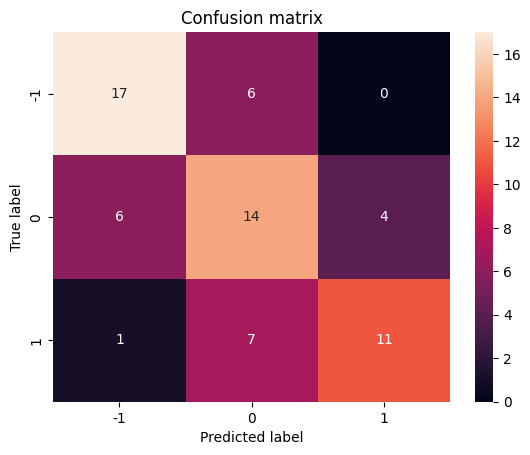

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.636364,0.639828,0.653395,0.633804,0.76559


In [11]:
metric, model = calc_metrics_on_lr(bow, name='bow l1 only release', solver='liblinear', penalty='l1')
metrics = pd.concat([min_baseline, metric], axis=0)
metrics = pd.concat([min_baseline, metric], axis=0)
metrics

Качество даже хуже минимального бейзлайна, попробуем обучить модель c l2 регуляризацией, и только на тех словах, веса при которых не занулила прошлая модель.

              precision    recall  f1-score   support

        -1.0       0.76      0.70      0.73        23
         0.0       0.57      0.71      0.63        24
         1.0       0.80      0.63      0.71        19

    accuracy                           0.68        66
   macro avg       0.71      0.68      0.69        66
weighted avg       0.70      0.68      0.69        66



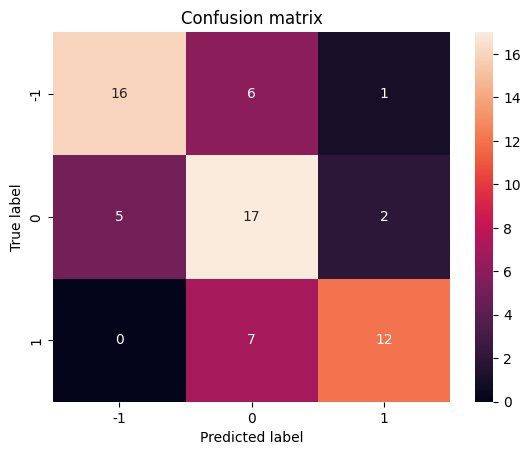

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.636364,0.639828,0.653395,0.633804,0.76559
bow l2,0.681818,0.687595,0.709524,0.678521,0.84802


In [12]:
metric, _ = calc_metrics_on_lr(bow[:, np.any(model.coef_ != 0, axis=0)], name='bow l2', solver='newton-cg', penalty='l2')
metrics = pd.concat((metrics, metric))
metrics


Качество немного подросло попробуем обучить мешок слов на переменной `title`

In [13]:
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words=list(stopwords.words('russian')),
    tokenizer=word_tokenize,
    preprocessor=preprocessor,
)

vectorizer.fit(X.title)

bow_title = vectorizer.transform(X.title)

/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['весь', 'свой', 'это'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       0.76      0.70      0.73        23
         0.0       0.57      0.71      0.63        24
         1.0       0.80      0.63      0.71        19

    accuracy                           0.68        66
   macro avg       0.71      0.68      0.69        66
weighted avg       0.70      0.68      0.69        66



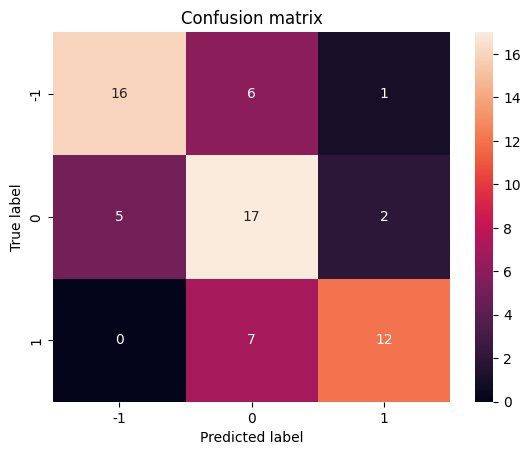

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.636364,0.639828,0.653395,0.633804,0.765590
bow l2,0.681818,0.687595,0.709524,0.678521,0.848020
bow add title,0.681818,0.687595,0.709524,0.678521,0.846992


In [14]:
bow_title_release = np.concatenate((bow[:, np.any(model.coef_ != 0, axis=0)].toarray(), bow_title.toarray()), axis=1)
metric, _ = calc_metrics_on_lr(bow_title_release, penalty='l2', name='bow add title', solver='newton-cg')
metrics = pd.concat([metrics, metric])
metrics

Добавление мешка слов по названию не улучшило нашу модель, а только усложнило ее. Попробуем к мешку слов по тектам релизов, с самыми важными словами добавим количественные признаки.

              precision    recall  f1-score   support

        -1.0       0.76      0.70      0.73        23
         0.0       0.55      0.71      0.62        24
         1.0       0.79      0.58      0.67        19

    accuracy                           0.67        66
   macro avg       0.70      0.66      0.67        66
weighted avg       0.69      0.67      0.67        66



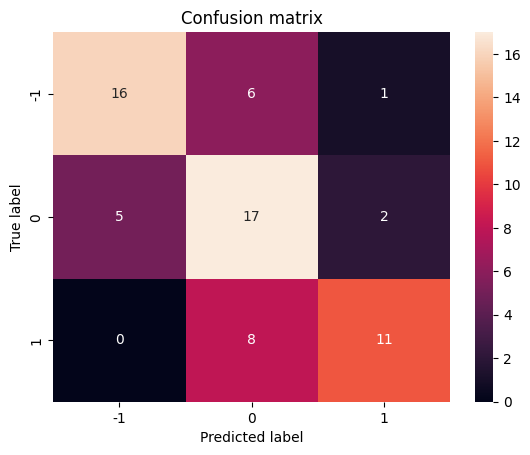

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.636364,0.639828,0.653395,0.633804,0.765590
bow l2,0.681818,0.687595,0.709524,0.678521,0.848020
bow add title,0.681818,0.687595,0.709524,0.678521,0.846992
bow release add all num,0.666667,0.670707,0.698669,0.660978,0.814005


In [15]:
data = np.concatenate((bow[:, np.any(model.coef_ != 0, axis=0)].toarray(), X.drop(['title', 'release'], axis=1).values), axis=1)

metric, _ = calc_metrics_on_lr(data, solver='newton-cg', name='bow release add all num', penalty='l2')

metrics = pd.concat([metrics, metric])
metrics

Добавление количественных переменных только ухудшило нашу модель.